In [1]:
from datetime import datetime
from random import random
run_id = f"{datetime.now():%Y-%m-%d}-{1000 * random():04.0f}"
PROFILE= 'render_notebook'
MODEL_NAME = f'sarima-{run_id}'
CI_MODEL_NAME = 'sarima-model-ci'
SARIMA_LIB='./custom_lib'

## SARIMA on BYOML
In this notebook we will demonstrate how you can use a statistical  model like SARIMA, upload it to byoml and afterwards perform a (forecasting) prediction with the deployed model.

This uses the `custom` framework, supported by BYOML since version `1.4.0`, to use the [statsmodels](https://www.statsmodels.org) implementation of [SARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarima#statsmodels.tsa.statespace.sarimax.SARIMAX).

We use WPI data from [stata](https://www.stata-press.com/data/). See also Example 5 in [this](https://www.stata.com/manuals/tsforecastestimates.pdf) stata manual.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import httpx
import statsmodels.api as sm
from http import HTTPStatus

from io import BytesIO

from sarima_byoml_wrapper import convert_to_pandas, convert_to_numpy, SARIMAXConfidenceForecaster, SARIMAXForecaster

In [3]:
wpi1 = httpx.get('https://www.stata-press.com/data/r17/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
# set quarter index frequency: not necessary, but suppresses warnings
data.index.freq='QS'
data = data[['wpi']]

<AxesSubplot:xlabel='t'>

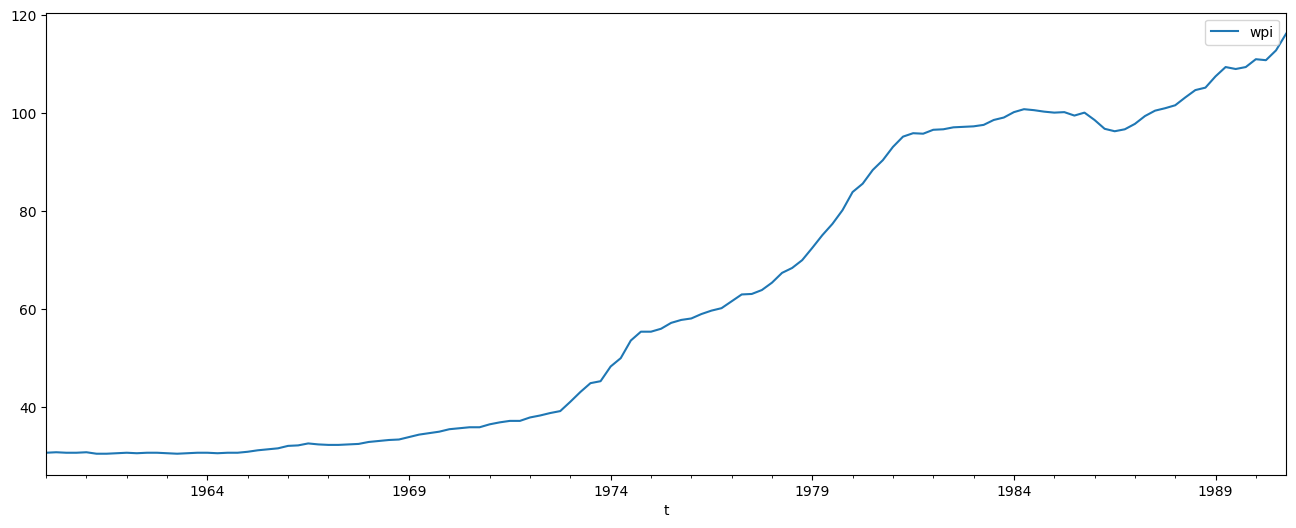

In [4]:
data.plot(figsize = (16, 6))

#### train and test data

In [5]:
train_size = int(len(data.index) * 0.9)
df_train, df_test = data.iloc[:train_size], data.iloc[train_size:]
print(df_train.head())
print(df_test.head())

                  wpi
t                    
1960-01-01  30.700001
1960-04-01  30.799999
1960-07-01  30.700001
1960-10-01  30.700001
1961-01-01  30.799999
                   wpi
t                     
1987-10-01  101.000000
1988-01-01  101.599998
1988-04-01  103.199997
1988-07-01  104.699997
1988-10-01  105.199997


#### model fitting

This sarima model uses hyperparameters that set first order (`1,1,1`) modeling on the autoregression (AR), differencing (I), and moving average (MA) parts, both for the 1-step prediction (`order`) as for the seasonal (S) component (`seasonal_order`). 

We set a seasonality of `4` for a yearly season on quarterly data.

We do not use the _exogenous_ (X) component supported by this model.

First we will create a local model, later we can compare results of the served model to this local model.

In [6]:
model = sm.tsa.SARIMAX(
    df_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4),
)
fitted_model = model.fit(maxiter=250, disp=10)
fitted_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09970D+00    |proj g|=  2.19501D-01

At iterate   10    f=  9.82291D-01    |proj g|=  2.09852D-02

At iterate   20    f=  9.79926D-01    |proj g|=  2.43336D-03

At iterate   30    f=  9.79780D-01    |proj g|=  2.32556D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     62      1     0     0   1.155D-03   9.798D-01
  F =  0.97977439205787609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               wpi   No. Observations:                  111
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -108.755
Date:                           Tue, 09 May 2023   AIC                            227.510
Time:                                   14:51:26   BIC                            240.827
Sample:                               01-01-1960   HQIC                           232.907
                                    - 07-01-1987                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8557      0.071     11.969      0.000       0.716       0.996
ma.L1         -0.3205      0.127     -2.527      0.012      -0.569      -0.072
ar.S.L4        0.1429      0.127      1.129      0.259      -0.105       0.391
ma.S.L4       -0.9989      5.299     -0.188      0.850     -11.386       9.388
sigma2         0.4090      2.162      0.189      0.850      -3.828       4.646
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.29
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              21.40   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

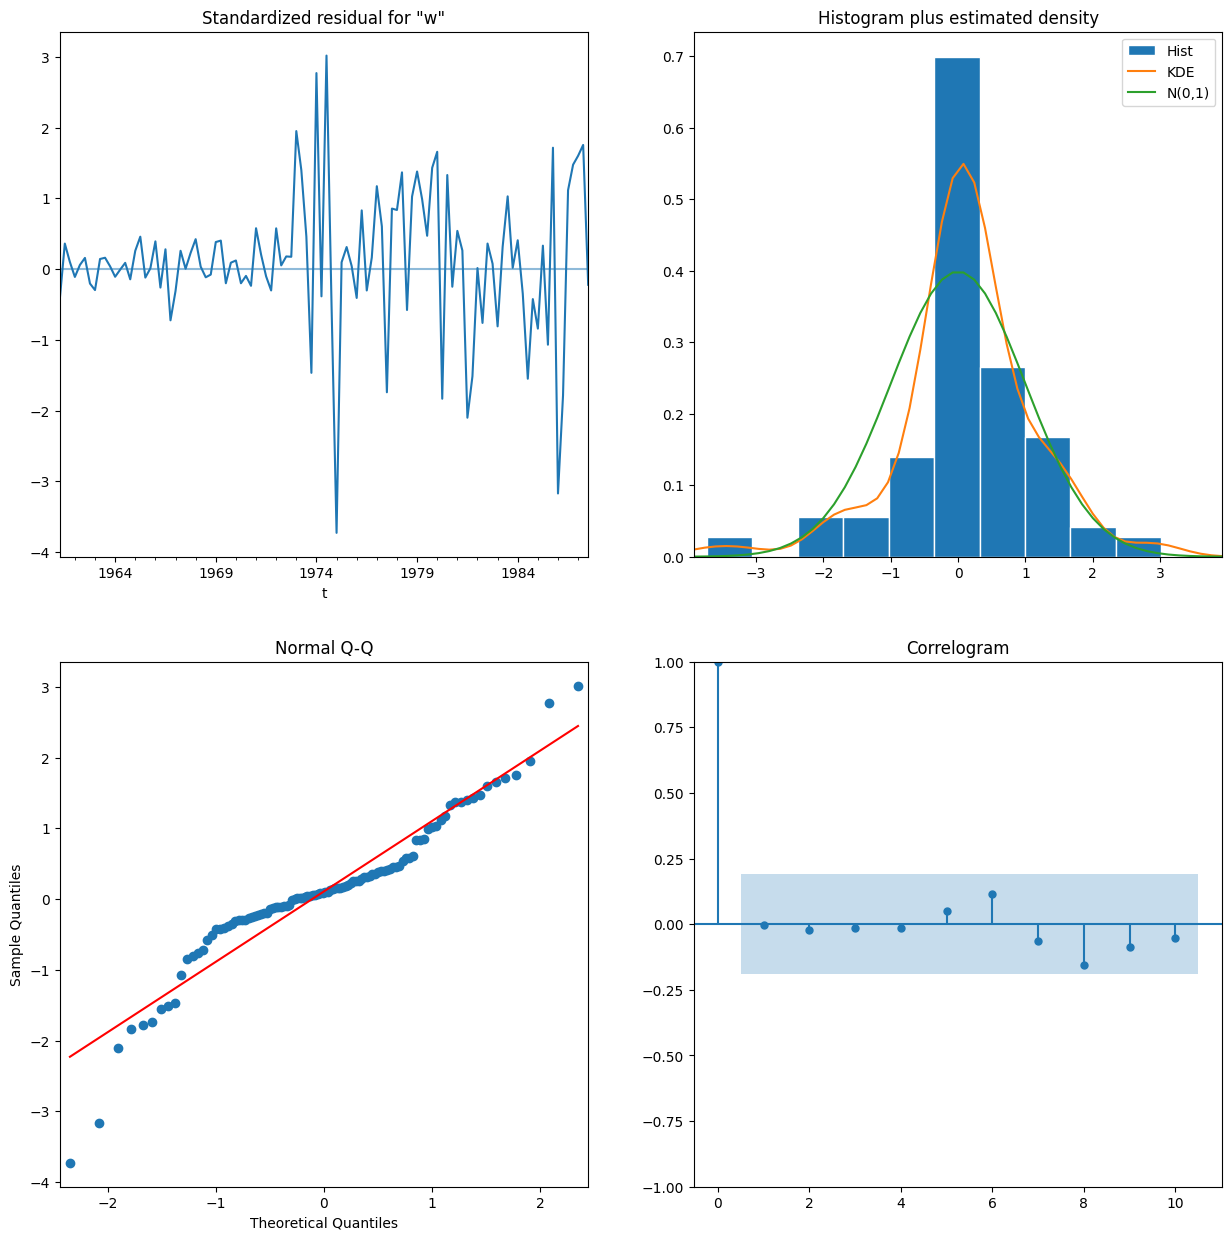

In [7]:
diag_plot = fitted_model.plot_diagnostics(figsize=(15, 15))


#### one-step forecast (in-band)
The following cell performs a one-step ahead forecast of the 30 latest data points.

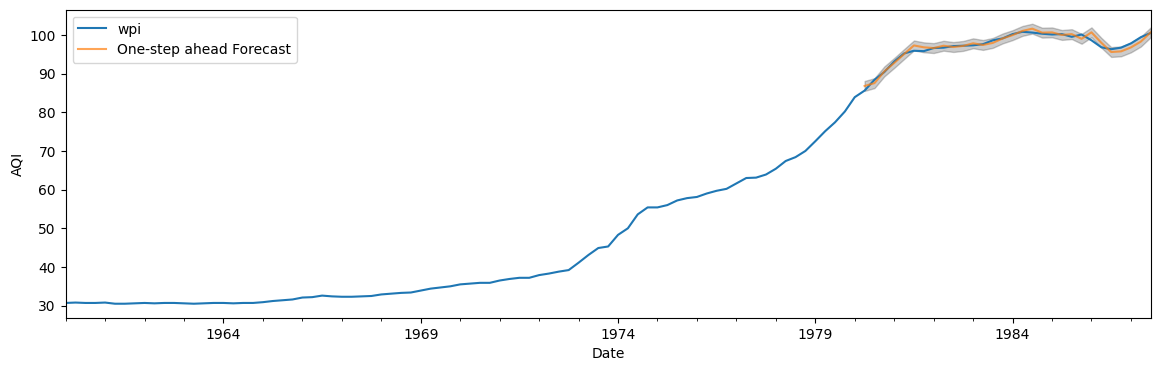

In [8]:
prediction = fitted_model.get_prediction(start=-30)
pred_ci = prediction.conf_int(alpha=0.05)
pred_mean = prediction.predicted_mean
ax = df_train.plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

#### forecast (future prediction)

The `forecast` method of the fitted model will give you predictions in the future.

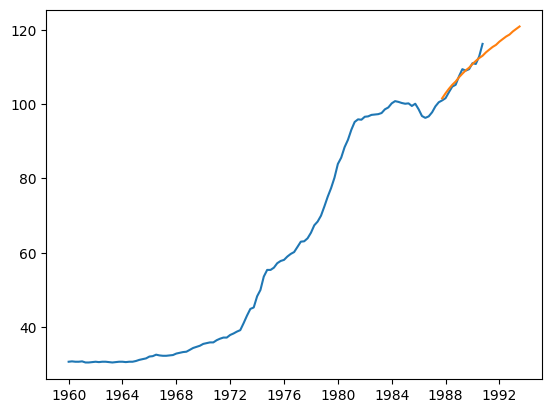

In [9]:
forecast_window = 24
forecast = fitted_model.forecast(steps=forecast_window)
plt.plot(data.index, data.wpi)
plt.plot(forecast.index, forecast.values)

The `get_forecast` method also gives confidence intervals.

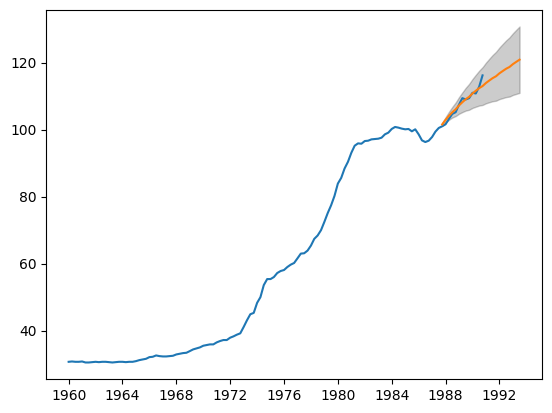

In [10]:
forecast = fitted_model.get_forecast(steps=forecast_window)
forecast_mean = forecast.predicted_mean
# using a 50% confidence interval:
forecast_ci = forecast.conf_int(alpha=0.5)
plt.plot(data.index, data.wpi)
plt.plot(forecast_mean.index, forecast_mean.values)
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1], 
    color='k', alpha=.2
)
plt.show()

Let's create a custom BYOML model wrapper that we can fit and deploy to BYOML.
We set up the waylay client. 

In [11]:
from waylay import WaylayClient, RestResponseError, __version__
waylay = WaylayClient.from_profile(PROFILE)

# diagnostis
display(__version__)
display(waylay.byoml.root_url)
display(waylay.byoml.about.health())


'v0.5.0'

'https://api.waylay.io/ml/v1'

{'name': 'byoml', 'version': '1.5.3'}

## data conversion
Our model uses use pandas timeseries, but when deployed, the byoml runtime hands over numpy arrays to the `predict` method.

The functions used below convert from and to numpy arrays of shape (nr_of_observations, len(feature_columns + 1)). They are defined in a custom library that has been included. The inner records are a (timestamp, value) with timestamps encoded as epoch milliseconds, e.g. as produced by the `executeQuery`(http://docs-io.waylay.io/#/sensors/executeQuery) plug with the `removeTimestamps=false` option.

A typical request that would be sent to the deployed byoml function would be (`Content-Type: application/json`)
```http
POST /models/sarima-model/predict 
{
  "instances" : [
     [-315619200000.0, 30.700000762939453],
     [-307756800000.0, 30.799999237060547],
     [-299894400000.0, 30.700000762939453],
     ...
  ]
}
```

Check these functions with a roundtrip on the first lines of our data set:

In [12]:
json_data = convert_to_numpy(data.head()).tolist()
display(json_data)
pandas_data = convert_to_pandas(json_data)
display(pandas_data)

[[-315619200000.0, 30.700000762939453],
 [-307756800000.0, 30.799999237060547],
 [-299894400000.0, 30.700000762939453],
 [-291945600000.0, 30.700000762939453],
 [-283996800000.0, 30.799999237060547]]

,value
1960-01-01,30.700001
1960-04-01,30.799999
1960-07-01,30.700001
1960-10-01,30.700001
1961-01-01,30.799999


## Byoml Model wrapper

The helper class around the SARIMA model, `SARIMAXForecaster`, that was included above is used. Here, we test the predict method locally.

In [13]:
# fit and test the wrapped model
upload_model = SARIMAXForecaster()
upload_model.fit(df_train, disp=0)
preds_df = upload_model.predict(df_train)
preds_df.head()

1987-10-01    101.215103
1988-01-01    102.439452
1988-04-01    103.809061
1988-07-01    104.943745
1988-10-01    105.799706
Freq: QS-JAN, Name: predicted_mean, dtype: float64

We can check if the data conversion functions used above work correctly with the model we will upload:

In [14]:
## this would be the data sent to byoml
json_data_req = { 'instances': convert_to_numpy(df_train).tolist() }

## these are the steps the byoml service will invoke on the model wrapper
mapped_input = upload_model.map_input(json_data_req)
preds_df = upload_model.predict(mapped_input)
mapped_output = upload_model.map_output(json_data_req, preds_df)

## this would be the response data sent back
display(mapped_output)

{'predictions': [[560044800000.0, 101.21510338443233],
  [567993600000.0, 102.43945209512108],
  [575856000000.0, 103.80906145925209],
  [583718400000.0, 104.9437448154566],
  [591667200000.0, 105.79970630794074],
  [599616000000.0, 107.07738401412374],
  [607392000000.0, 108.33745314588052],
  [615254400000.0, 109.48450326608331],
  [623203200000.0, 110.40172540508073],
  [631152000000.0, 111.70055448396292],
  [638928000000.0, 112.90704612841427],
  [646790400000.0, 114.05663177268353],
  [654739200000.0, 114.99895224382364],
  [662688000000.0, 116.30454546980766],
  [670464000000.0, 117.48355759999622],
  [678326400000.0, 118.63153466196509],
  [686275200000.0, 119.58269953170452],
  [694224000000.0, 120.88879666885572],
  [702086400000.0, 122.05265976160277],
  [709948800000.0, 123.197452961546],
  [717897600000.0, 124.15031268128956],
  [725846400000.0, 125.45434605591541],
  [733622400000.0, 126.60902465915252],
  [741484800000.0, 127.75020002891434]]}

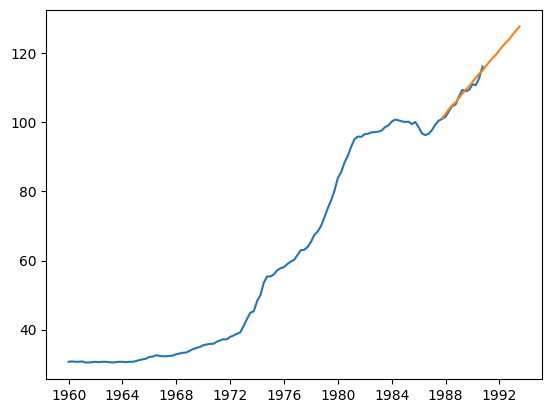

In [15]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(preds_df.index, preds_df.values)

Define the model name for this notebook, delete any model with that name that would already exist. 

In [16]:

try:
    resp = waylay.byoml.model.remove(MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'No model 'sarima-2023-05-09-0613''; DELETE 'https://api.waylay.io/ml/v1/models/sarima-2023-05-09-0613')"

Now we deploy our model on BYOML. When uploading, we add the library that contains the wrapper classes and that was used for data conversion as a requirement. 

In [17]:
# check wether your deployment supports the `custom` framework
waylay.byoml.framework.get('custom')

{'default_runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'framework': 'custom',
 'versions': ['1.0']}

In [20]:
waylay.byoml.model.upload(
    MODEL_NAME,
    upload_model,
    framework='custom',
    description='SARIMA model example',
    requirements='lib/sarima_byoml_wrapper',
    lib=SARIMA_LIB
)

ByomlActionError: ByomlActionError(409: 'A kfserving entity with this name and version already exists'; POST 'https://api.waylay.io/ml/v1/models')

Listing the models won't affect the deployment status of the model

In [26]:
waylay.byoml.model.list_names(params={"name":MODEL_NAME})

['sarima-model']

Getting the model, will check that the model is ready to serve ...

In [27]:
waylay.byoml.model.get(MODEL_NAME, params={"debug": True})

{'createdBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'createdOn': '2022-09-06T11:24:22.121000+00:00',
 'description': 'SARIMA model example',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example'},
 'name': 'sarima-model',
 'ready': True,
 'runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'semantic_version': '0.0.1',
 'serving_name': 'kf-ec3e2065819e9ca6636b6b18d061873dd0502121.openfaas-fn-66417857-9f49-4a83-9307-e12ad5fbda45',
 'status': 'running',
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'updatedOn': '2022-09-06T11:24:56.282000+00:00',
 'version': '1'}

When requesting predictions, the python SDK will retry until the model is ready to serve (see [retry handling](http://docs-io.waylay.io/#/api/sdk/python?id=retry-handling))

In [28]:
predictions = waylay.byoml.model.predict(MODEL_NAME, convert_to_numpy(df_train))
predictions_df = convert_to_pandas(predictions)
predictions_df.head()

,value
1987-10-01,101.215103
1988-01-01,102.439452
1988-04-01,103.809061
1988-07-01,104.943745
1988-10-01,105.799706


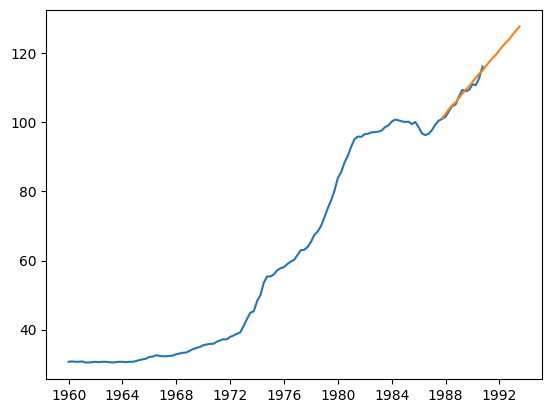

In [29]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(
    predictions_df.index,
    predictions_df.values
)

In [30]:
# remove the deployed model
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model sarima-model: all versions deleted',
 'name': 'sarima-model',
 'versions': ['0.0.1']}

##  parameterization: confidence intervals


Let's adapt the model to support confidence intervals instead of mean predictions. This also shows how you can pass custom parameters to you model inference.

In [31]:
try:
    resp = waylay.byoml.model.remove(CI_MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

{'message': 'Model sarima-model-ci: all versions deleted',
 'name': 'sarima-model-ci',
 'versions': []}

Here, we use another custom wrapper class, `SARIMAXConfidenceForecaster`, that was included above.

In [32]:
upload_model_ci = SARIMAXConfidenceForecaster()
upload_model_ci.fit(df_train, disp=0)

# test locally
upload_model_ci.predict(( df_train, 0.5)).head()

,lower wpi,upper wpi
1987-10-01,99.587552,102.842655
1988-01-01,100.173203,104.705701
1988-04-01,101.076452,106.541671
1988-07-01,101.836353,108.051136
1988-10-01,101.967948,109.631465


Once again, we have to add the library that contains, among others, this custom wrapper class as a requirement.

In [33]:
# upload model
try:
    waylay.byoml.model.upload(
        CI_MODEL_NAME,
        upload_model_ci,
        framework='custom',
        description='SARIMA model example with confidence intervals',
        requirements='lib/sarima_byoml_wrapper',
        lib=SARIMA_LIB
    )
except RestResponseError as e:
    assert e.response.status_code == HTTPStatus.BAD_GATEWAY
    print('KNOWN issue: ignoring a BAD_GATEWAY error upon model deployment')

KNOWN issue: ignoring a BAD_GATEWAY error upon model deployment


In [34]:
waylay.byoml.model.get(CI_MODEL_NAME, params={'debug': True})

{'createdBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'createdOn': '2022-09-06T11:26:46.134000+00:00',
 'description': 'SARIMA model example with confidence intervals',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example with confidence intervals'},
 'name': 'sarima-model-ci',
 'ready': False,
 'runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'semantic_version': '0.0.1',
 'serving_name': 'kf-bd0fe4288f3bd69c37b229c242332c01f49c55c2.openfaas-fn-66417857-9f49-4a83-9307-e12ad5fbda45',
 'status': 'running',
 'supported_endpoints': [],
 'updatedBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'updatedOn': '2022-09-06T11:26:46.142000+00:00',
 'version': '1'}

Now, we can compare the results of our uploaded model to the local results we calculated above. 


In [37]:
predictions = waylay.byoml.model.predict(CI_MODEL_NAME, convert_to_numpy(df_train))
redictions_df = convert_to_pandas(predictions, ['ci_low', 'ci_high'])
predictions_df.head()

,ci_low,ci_high
1987-10-01,99.587552,102.842655
1988-01-01,100.173203,104.705701
1988-04-01,101.076452,106.541671
1988-07-01,101.836353,108.051136
1988-10-01,101.967948,109.631465


In [38]:
# use the `body` argument to add additional parameters in a prediction request
predictions = waylay.byoml.model.predict(CI_MODEL_NAME, convert_to_numpy(df_train), body={'alpha': 0.5})
predictions_df = convert_to_pandas(predictions, ['ci_low', 'ci_high'])
predictions_df.head()

,ci_low,ci_high
1987-10-01,99.587552,102.842655
1988-01-01,100.173203,104.705701
1988-04-01,101.076452,106.541671
1988-07-01,101.836353,108.051136
1988-10-01,101.967948,109.631465


In [39]:
waylay.byoml.model.remove(CI_MODEL_NAME)

{'message': 'Model sarima-model-ci: all versions deleted',
 'name': 'sarima-model-ci',
 'versions': ['0.0.1']}